<img src="TrumpvsBiden1.jpg">

In [68]:
import sys
import tweepy
import csv
import pandas as pd
import time
import time
import numpy as np
import itertools

import requests
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

import re
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

from googletrans import Translator
translator = Translator()

#pass security information to variables
consumer_key = 'Fkq1YtWMXJfm7rqFQe6bUMKnk'
consumer_secret = 'tbQFEXaYskF6vfHMN0xpBhjuDGIYP6vpNk4TYEsbn3ETOj6YKY'
access_token = '1254116935006072833-4lYrmDIsHq9wbVan3VDtdzwkeWe6Nc'
access_token_secret = 'f9zpd5uYABZCiK28Cixp5kR3dy6bFbXybDfwiWRMFvaa3'
auth= tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api= tweepy.API(auth, wait_on_rate_limit= True)



In [84]:
!pip install googletrans

     |████████████████████████████████| 61kB 2.6MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 972kB 6.6MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=b905fcc1e96f179ad653d4d137b32acf9b5a12f3e9e6aeb73bd77575680e1ec8
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=cd518520ec5ed9fce540e475c162d4a1b63d93b92011015cc8e7cbe9927b3b06
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [85]:
def sentiment_analyzer_scores(text, engl=True):
    if engl:
        trans = text
    else:
        trans = translator.translate(text).text

    score = analyser.polarity_scores(trans)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

In [86]:
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)

    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

In [71]:
def twitter_stream_listener(file_name,
                            filter_track,
                            follow=None,
                            locations=None,
                            languages=None,
                            time_limit=20):
    class CustomStreamListener(tweepy.StreamListener):
        def __init__(self, time_limit):
            self.start_time = time.time()
            self.limit = time_limit
            # self.saveFile = open('abcd.json', 'a')
            super(CustomStreamListener, self).__init__()
        def on_status(self, status):
            if (time.time() - self.start_time) < self.limit:
                print(".", end="")
                # Writing status data
                with open(file_name, 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([
                        status.author.screen_name, status.created_at,
                        status.text
                    ])
            else:
                print("\n\n[INFO] Closing file and ending streaming")
                return False
        def on_error(self, status_code):
            if status_code == 420:
                print('Encountered error code 420. Disconnecting the stream')
                # returning False in on_data disconnects the stream
                return False
            else:
                print('Encountered error with status code: {}'.format(
                    status_code))
                return True  # Don't kill the stream
        def on_timeout(self):
            print('Timeout...')
            return True  # Don't kill the stream
    # Writing csv titles
    print(
        '\n[INFO] Open file: [{}] and starting {} seconds of streaming for {}\n'
        .format(file_name, time_limit, filter_track))
    with open(file_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['author', 'date', 'text'])
    streamingAPI = tweepy.streaming.Stream(
        auth,CustomStreamListener(time_limit=time_limit))
    streamingAPI.filter(
        track=filter_track,
        follow=follow,
        locations=locations,
        languages=languages,
    )
    f.close()

In [72]:
filter_track=['Trump','Biden']
file_name= 'TrumpvsBiden.csv'
twitter_stream_listener(file_name,filter_track,time_limit=150)


[INFO] Open file: [TrumpvsBiden.csv] and starting 150 seconds of streaming for ['Trump', 'Biden']

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [73]:
df= pd.read_csv("TrumpvsBiden.csv")
df.head()

,author,date,text
0,R0nnieBergman,2020-10-31 09:24:34,RT @standardnews: I created The Thick of It an...
1,Godhelpusameric,2020-10-31 09:24:34,RT @realDonaldTrump: “A Biden win would mean t...
2,Zehub,2020-10-31 09:24:34,VIDEO. Election présidentielle aux États-Unis ...
3,JamieParrigin,2020-10-31 09:24:34,RT @realDonaldTrump: President Obama used to s...
4,Powerfader54,2020-10-31 09:24:34,Tucker Carlson: Hunter Biden scandal shows med...


In [74]:
df.shape

(4254, 3)

In [76]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [77]:
def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")

    return lst

In [87]:
df['text'] =  clean_tweets(df['text'])


In [88]:
df.head()

,author,date,text,sent
0,R0nnieBergman,2020-10-31 09:24:34,I created The Thick of It and Veep but Donald...,0
1,Godhelpusameric,2020-10-31 09:24:34,“A Biden win would mean the end of Fracking i...,0
2,Zehub,2020-10-31 09:24:34,VIDEO. Election présidentielle aux États-Unis ...,0
3,JamieParrigin,2020-10-31 09:24:34,President Obama used to say that “if you want...,0
4,Powerfader54,2020-10-31 09:24:34,Tucker Carlson: Hunter Biden scandal shows med...,0


In [89]:
def anl_tweets(lst, title='Tweets Sentiment', engl=True ):
    sents = []
    for tw in lst:
        try:
            st = sentiment_analyzer_scores(tw, engl)
            sents.append(st)
        except:
            sents.append(0)
    ax = sns.distplot(
        sents,
        kde=False,
        bins=3)
    ax.set(xlabel='Negative                Neutral                 Positive',
           ylabel='#Tweets',
          title="Tweets of @"+title)
    return sents

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


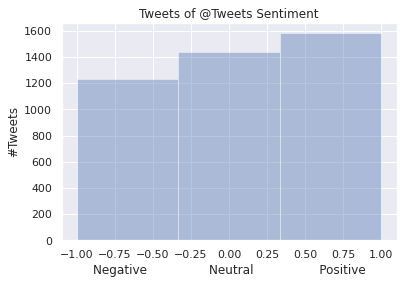

In [90]:
df['sent'] = anl_tweets(df.text)

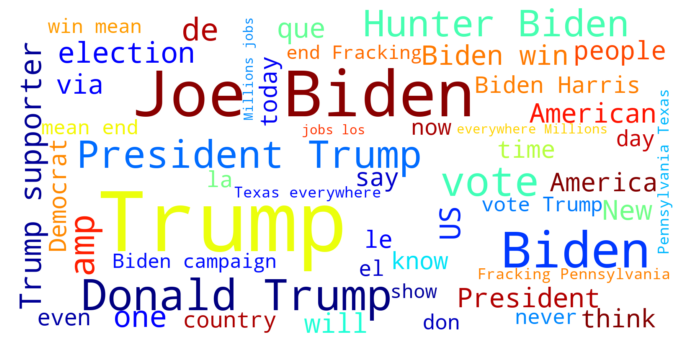

In [91]:
word_cloud(df.text)

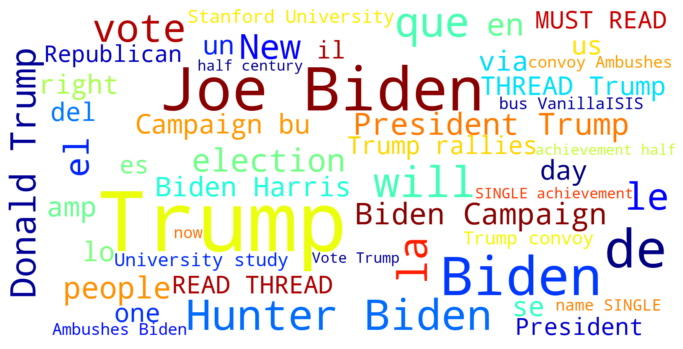

In [92]:
# Words in neutral tweets
neutral = df['text'][df['sent'] == 0]
word_cloud(neutral)

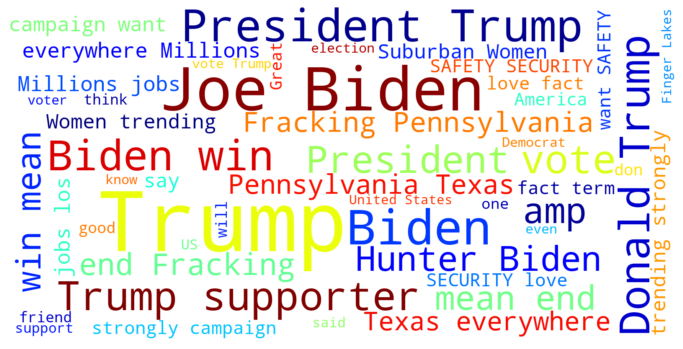

In [93]:
# Words in positive tweets
tws_pos = df['text'][df['sent'] == 1]
word_cloud(tws_pos)

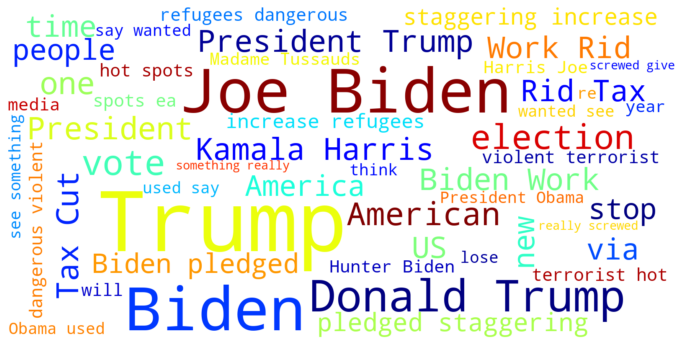

In [94]:
# Words in negative tweets
tws_neg = df['text'][df['sent'] == -1]
word_cloud(tws_neg)

In [95]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [96]:
# extracting hashtags from positive tweets

HT_positive = hashtag_extract(df['text'][df['sent'] == 1])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(df['text'][df['sent'] == -1])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

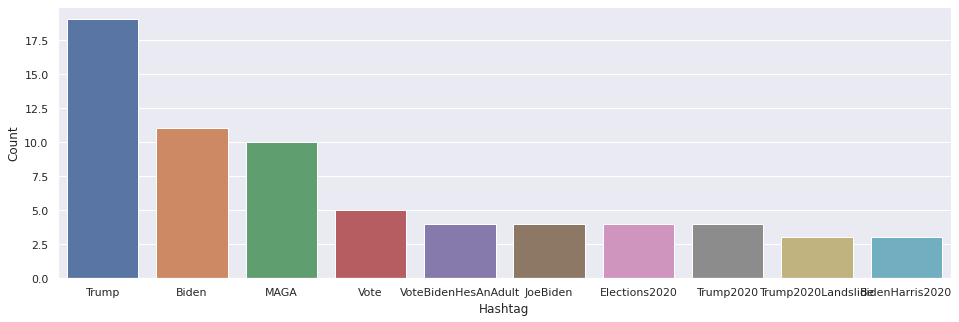

In [97]:
# Positive Tweets

a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

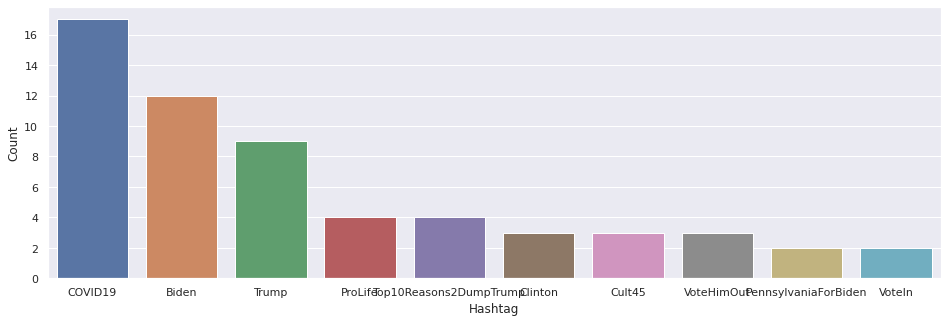

In [98]:
# Negative Tweets

b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()